# TP2: The Convolutional Neural Network
### Introduction to CNN and CIFAR-10 dataset
#### By: Alexandre Verine

In the practical session, we will implement a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. We will compare the results with a traditional Dense Neural Network (DNN) and a CNN.

In [1]:
import warnings

warnings.filterwarnings("ignore")

First, we load the necessary libraries:

In [2]:
# PyTorch library, provides tensor computation and deep neural networks
import torch

# Package that provides access to popular datasets and image transformations for computer vision
import torchvision
from torchvision import datasets, transforms

import torch.nn as nn  # Provides classes to define and manipulate neural networks
import torch.nn.functional as F  # Contains functions that do not have any parameters, such as relu, tanh, etc.
import torch.optim as optim  # Package implementing various optimization algorithms

# Library for the Python programming language, adding support for large, multi-dimensional arrays and matrices.
import numpy as np

import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations in Python

To accelerate the training of the CNN, we will use the GPU (NVIDIA CUDA), the TPU (Google Colab Pro) or the Apple Shared Neural Engine (M1/M2/M3 chip). 

In [3]:
# Set the device (cuda, cpu or mps)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Device used: {}".format(device))

Device used: cuda


The CIFAR-10 dataset is available in torchvision.datasets:

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many sampls per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Choose the training and test datasets
train_data = datasets.CIFAR10("data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10("data", train=False, download=True, transform=transform)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)


test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# specify the image classes
classes = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False

plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.sans-serif": ["Computer Modern Roman"],
    }
)

plt.rcParams["font.size"] = 13
plt.rcParams["legend.framealpha"] = 0.3


# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

We can load the first batch and display the images:

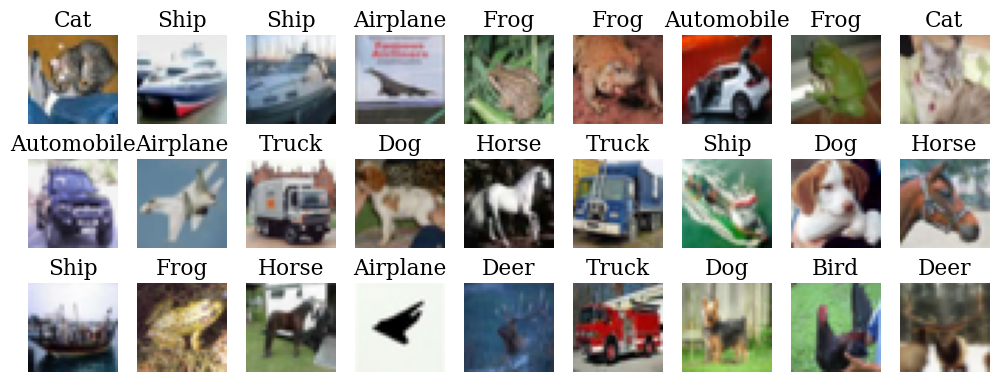

In [6]:
# Load the first batch of the test data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(27):
    ax = fig.add_subplot(3, 9, idx + 1, xticks=[], yticks=[])
    imshow(example_data[idx].detach().numpy())
    ax.set_title(classes[example_targets[idx]])
plt.tight_layout()
plt.show()

We can define the training/eval functions: 

In [7]:
def train_n_test(model, optimizer, nepochs, criterion, fname):
    # number of epochs to train the model
    n_epochs = [*range(1, nepochs + 1)]
    # List to store loss to visualize
    valid_loss_min = np.Inf  # track change in validation loss

    train_losses = []
    train_counter = []
    test_losses = []
    acc_eval = []
    test_counter = [i * len(train_loader.dataset) for i in n_epochs]

    for epoch in n_epochs:

        # keep track of training and validation loss
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move tensors to GPU/MPS if CUDA/MPS is available
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset))
            )

        ######################
        # validate the model #
        ######################
        model.eval()
        correct = 0
        for data, target in test_loader:
            # move tensors to GPU/MPS if CUDA/MPS is available
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item() * data.size(0)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = np.mean(train_losses[(epoch - 1) * len(train_loader) :])
        valid_loss = valid_loss / len(test_loader.dataset)
        acc_eval.append(correct / len(test_loader.dataset) * 100)
        test_losses.append(valid_loss)
        # print training/validation statistics
        print(
            "Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
                epoch, train_loss, valid_loss
            )
        )

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(
                "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                    valid_loss_min, valid_loss
                )
            )
            torch.save(model.state_dict(), fname)
            valid_loss_min = valid_loss

    torch.save(
        {
            "test_loss": (test_counter, test_losses),
            "train_loss": (train_counter, train_losses),
            "acc_eval": acc_eval,
        },
        f"res_{fname}.pt",
    )

In [31]:
def plot(fname):
    plt.figure(figsize=(10, 5))
    colors = ["#08457E", "#F44336"]
    x = torch.load(f"res_{fname}.pt")
    train_counter, train_losses = x["train_loss"]
    test_counter, test_losses = x["test_loss"]
    acc_eval = x["acc_eval"]
    plt.plot(
        train_counter,
        train_losses,
        color=colors[0],
        label="Train Loss",
    )
    plt.scatter(
        test_counter,
        test_losses,
        color=colors[1],
        zorder=+100,
        label="Test Loss",
    )
    plt.scatter(
        [test_counter[np.argmin(test_losses)]],
        [min(test_losses)],
        color="black",
        zorder=+200,
        label=(f"Best Accuracy: {max(acc_eval):.2f}%"),
    )
    plt.xlim([0, max(train_counter)])
    plt.ylim([0, 1.1 * max(train_losses)])
    plt.xlabel("Number of Examples Seen by the model")
    plt.ylabel("Cross-Entropy")
    plt.annotate(
        "",
        xy=(min(train_counter) - 0.3, max(train_losses) * 1.05),
        xytext=(min(train_counter) - 0.3, -0.05),
        arrowprops=dict(arrowstyle="->"),
        annotation_clip=False,
        zorder=-100,
    )
    plt.annotate(
        "",
        xy=(max(train_counter) + 10000, -0.0),
        xytext=(min(train_counter) - 1000, -0.0),
        arrowprops=dict(arrowstyle="->"),
        annotation_clip=False,
        zorder=-100,
    )
    plt.legend()

In [80]:
def plot_accuracies(fnames, names):
    num_models = len(fnames)
    blues = plt.cm.Blues(np.linspace(0, 1, num_models + 1))
    accs_eval = []
    plt.figure(figsize=(10, 5))
    for i, fname in enumerate(fnames):
        x = torch.load(f"res_{fname}.pt")
        test_counter, test_losses = x["test_loss"]
        acc_eval = x["acc_eval"]
        accs_eval.append(acc_eval)
        plt.plot(
            test_counter,
            acc_eval,
            color=blues[i + 1],
        )

    plt.legend(
        [
            f"{name} Best Accuracy: {max(acc_eval):.2f}%"
            for name, acc_eval in zip(names, accs_eval)
        ],
        loc="lower right",
    )
    for i, fname in enumerate(fnames):
        x = torch.load(f"res_{fname}.pt")
        test_counter, test_losses = x["test_loss"]
        acc_eval = x["acc_eval"]

        plt.scatter(
            [test_counter[np.argmax(acc_eval)]],
            [max(acc_eval)],
            color="black",
            zorder=+200,
        )
    plt.xlim([min(test_counter), max(test_counter)])
    plt.ylim([0, 100])
    plt.xlabel("Number of Examples Seen by the model")
    plt.ylabel("Accuracy")
    plt.annotate(
        "",
        xy=(min(test_counter) - 0.3, 105),
        xytext=(min(test_counter) - 0.3, -5),
        arrowprops=dict(arrowstyle="->"),
        annotation_clip=False,
        zorder=-100,
    )
    plt.annotate(
        "",
        xy=(max(test_counter) + 10000, -0.0),
        xytext=(min(test_counter) - 1000, -0.0),
        arrowprops=dict(arrowstyle="->"),
        annotation_clip=False,
        zorder=-100,
    )

We define the loss: 

In [9]:
criterion = nn.CrossEntropyLoss()

First we can define a Dende Neural Network (DNN) with 3 hidden layers:

In [10]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

We instantiate the DNN model, the optimizer and we can count the number of parameters:

In [11]:
model = FC().to(device)  # Create the model and move it to the device

In [12]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of parameters: ", params)

Number of parameters:  3426250


We can train the DNN model:

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.001)  # Define the optimizer
train_n_test(model, optimizer, 30, criterion, "sgd_cifar_fc.pt")

Epoch: 1 	Training Loss: 2.298408 	Validation Loss: 2.293379
Validation loss decreased (inf --> 2.293379).  Saving model ...
Epoch: 2 	Training Loss: 2.287825 	Validation Loss: 2.282024
Validation loss decreased (2.293379 --> 2.282024).  Saving model ...
Epoch: 3 	Training Loss: 2.275021 	Validation Loss: 2.267214
Validation loss decreased (2.282024 --> 2.267214).  Saving model ...
Epoch: 4 	Training Loss: 2.257316 	Validation Loss: 2.245834
Validation loss decreased (2.267214 --> 2.245834).  Saving model ...
Epoch: 5 	Training Loss: 2.231110 	Validation Loss: 2.214038
Validation loss decreased (2.245834 --> 2.214038).  Saving model ...
Epoch: 6 	Training Loss: 2.193528 	Validation Loss: 2.170689
Validation loss decreased (2.214038 --> 2.170689).  Saving model ...
Epoch: 7 	Training Loss: 2.147381 	Validation Loss: 2.122519
Validation loss decreased (2.170689 --> 2.122519).  Saving model ...
Epoch: 8 	Training Loss: 2.100531 	Validation Loss: 2.076545
Validation loss decreased (2.12251

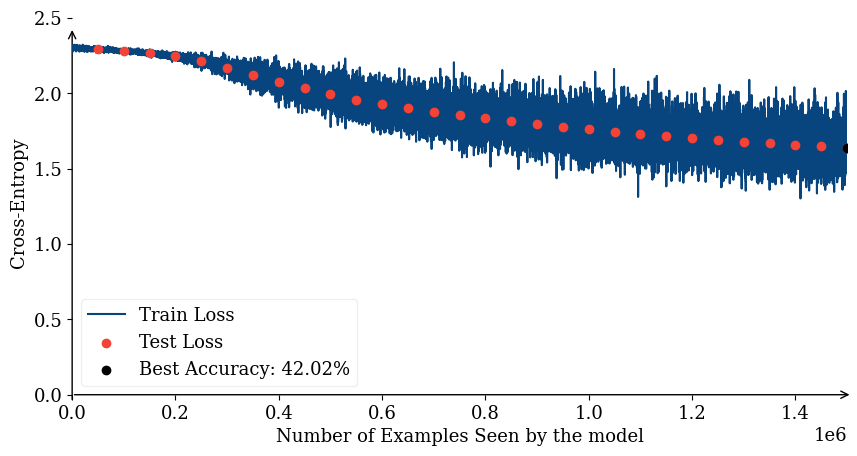

In [ ]:
plot("sgd_cifar_fc.pt")

By using Adam optimizer, we reach a better performance:

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Define the optimizer
train_n_test(model, optimizer, 30, criterion, "adam_cifar_fc.pt")

Epoch: 1 	Training Loss: 1.647408 	Validation Loss: 1.517360
Validation loss decreased (inf --> 1.517360).  Saving model ...
Epoch: 2 	Training Loss: 1.452193 	Validation Loss: 1.451674
Validation loss decreased (1.517360 --> 1.451674).  Saving model ...
Epoch: 3 	Training Loss: 1.342919 	Validation Loss: 1.386244
Validation loss decreased (1.451674 --> 1.386244).  Saving model ...
Epoch: 4 	Training Loss: 1.251634 	Validation Loss: 1.386287
Epoch: 5 	Training Loss: 1.171663 	Validation Loss: 1.347294
Validation loss decreased (1.386244 --> 1.347294).  Saving model ...
Epoch: 6 	Training Loss: 1.097073 	Validation Loss: 1.361448
Epoch: 7 	Training Loss: 1.026438 	Validation Loss: 1.386757
Epoch: 8 	Training Loss: 0.948088 	Validation Loss: 1.403232
Epoch: 9 	Training Loss: 0.882839 	Validation Loss: 1.444463
Epoch: 10 	Training Loss: 0.814854 	Validation Loss: 1.502697
Epoch: 11 	Training Loss: 0.756677 	Validation Loss: 1.604978
Epoch: 12 	Training Loss: 0.703948 	Validation Loss: 1.6

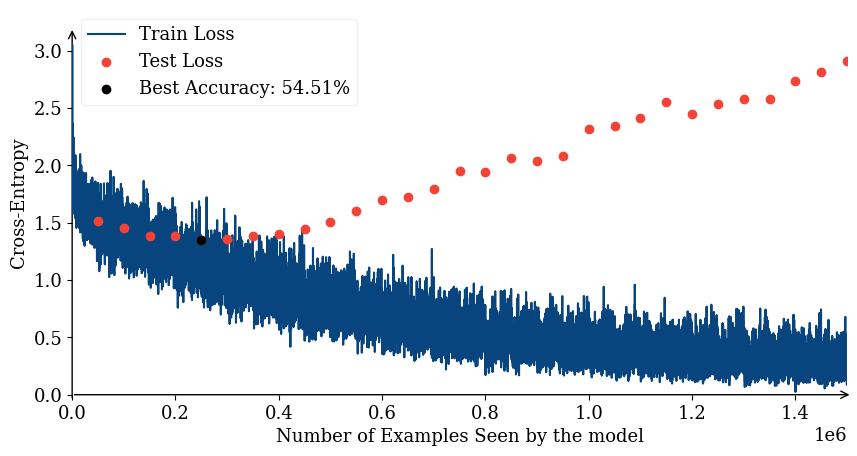

In [63]:
plot("adam_cifar_fc.pt")

By comparing the two optimizers, we can see that the Adam optimizer converges faster than the SGD optimizer:

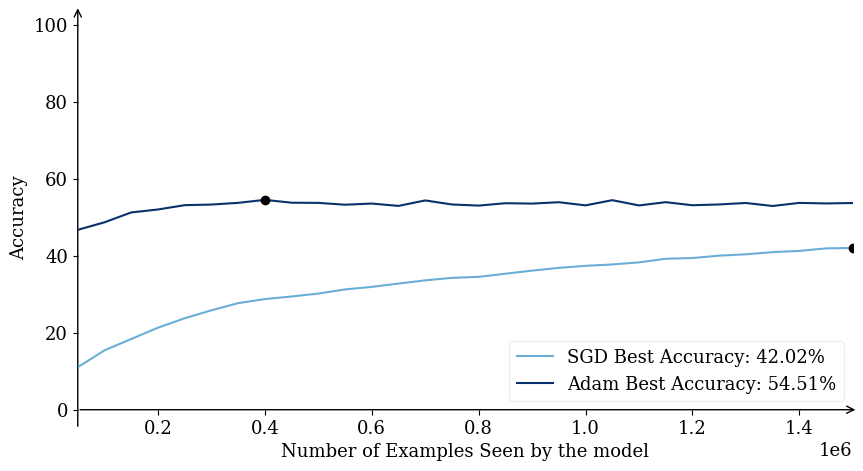

In [82]:
plot_accuracies(["sgd_cifar_fc.pt", "adam_cifar_fc.pt"], ["SGD", "Adam"])

We consider now a small CNN with 2 convolutional layers and 3 fully connected layers:

In [18]:
class CNN(nn.Module):
    def __init__(self):  # Define the layers of the network
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            3, 6, 5
        )  # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 kernel
        self.conv2 = nn.Conv2d(
            6, 16, 5
        )  # 6 input channels, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(
            16 * 5 * 5, 120
        )  # 16x5x5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84)  # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10)  # 84 input features, 10 output features

    def forward(self, x):  # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We instantiate the CNN model, the optimizer and we can count the number of parameters:

In [19]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Define the optimizer
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of parameters: ", params)

Number of parameters:  62006


The CNN has less parameters than the DNN ! 

We train the model using Adam: 

In [20]:
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_n_test(model, optimizer, 30, criterion, "cifar_cnn.pt")

Epoch: 1 	Training Loss: 1.659091 	Validation Loss: 1.426273
Validation loss decreased (inf --> 1.426273).  Saving model ...
Epoch: 2 	Training Loss: 1.348434 	Validation Loss: 1.260200
Validation loss decreased (1.426273 --> 1.260200).  Saving model ...
Epoch: 3 	Training Loss: 1.211291 	Validation Loss: 1.190875
Validation loss decreased (1.260200 --> 1.190875).  Saving model ...
Epoch: 4 	Training Loss: 1.124590 	Validation Loss: 1.120725
Validation loss decreased (1.190875 --> 1.120725).  Saving model ...
Epoch: 5 	Training Loss: 1.057546 	Validation Loss: 1.075490
Validation loss decreased (1.120725 --> 1.075490).  Saving model ...
Epoch: 6 	Training Loss: 1.002188 	Validation Loss: 1.051245
Validation loss decreased (1.075490 --> 1.051245).  Saving model ...
Epoch: 7 	Training Loss: 0.956595 	Validation Loss: 1.016638
Validation loss decreased (1.051245 --> 1.016638).  Saving model ...
Epoch: 8 	Training Loss: 0.913452 	Validation Loss: 1.027900
Epoch: 9 	Training Loss: 0.881005 

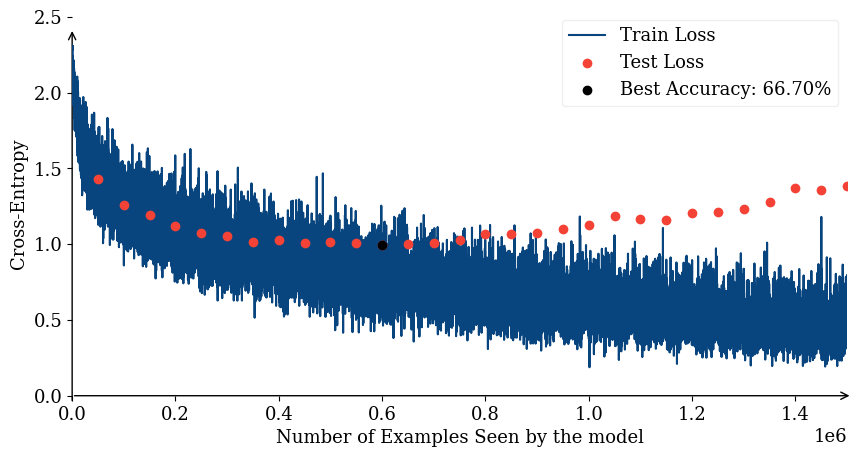

In [67]:
plot("cifar_cnn.pt")

What can we observe ?

We consider a larger/wider model with batch normalization and dropout:

In [54]:
class LargeCNN(nn.Module):
    def __init__(self, batch_norm=False, dropout=False):
        super(LargeCNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32) if batch_norm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_layer2 = nn.Sequential(
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128) if batch_norm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.15) if dropout else nn.Identity(),
        )
        self.conv_layer3 = nn.Sequential(
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256) if batch_norm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.15) if dropout else nn.Identity(),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10),
        )

    def conv_out(self, x, c):
        return self.conv_layer1(x)[:, c, :, :]

    def forward(self, x):
        """Perform forward."""

        # conv layers
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)
        return x

We instantiate the CNN model, the optimizer and we can count the number of parameters:

In [23]:
model = LargeCNN(batch_norm=False, dropout=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Number of parameters: ", params)

Number of parameters:  5851338


In [24]:
train_n_test(model, optimizer, 30, criterion, "cifar_large_cnn.pt")

Epoch: 1 	Training Loss: 1.599818 	Validation Loss: 1.204596
Validation loss decreased (inf --> 1.204596).  Saving model ...
Epoch: 2 	Training Loss: 0.997227 	Validation Loss: 0.885379
Validation loss decreased (1.204596 --> 0.885379).  Saving model ...
Epoch: 3 	Training Loss: 0.749767 	Validation Loss: 0.766493
Validation loss decreased (0.885379 --> 0.766493).  Saving model ...
Epoch: 4 	Training Loss: 0.608492 	Validation Loss: 0.732680
Validation loss decreased (0.766493 --> 0.732680).  Saving model ...
Epoch: 5 	Training Loss: 0.495372 	Validation Loss: 0.702470
Validation loss decreased (0.732680 --> 0.702470).  Saving model ...
Epoch: 6 	Training Loss: 0.392042 	Validation Loss: 0.738384
Epoch: 7 	Training Loss: 0.308529 	Validation Loss: 0.800675
Epoch: 8 	Training Loss: 0.238643 	Validation Loss: 0.824499
Epoch: 9 	Training Loss: 0.197688 	Validation Loss: 0.917873
Epoch: 10 	Training Loss: 0.163779 	Validation Loss: 0.975063
Epoch: 11 	Training Loss: 0.152591 	Validation Lo

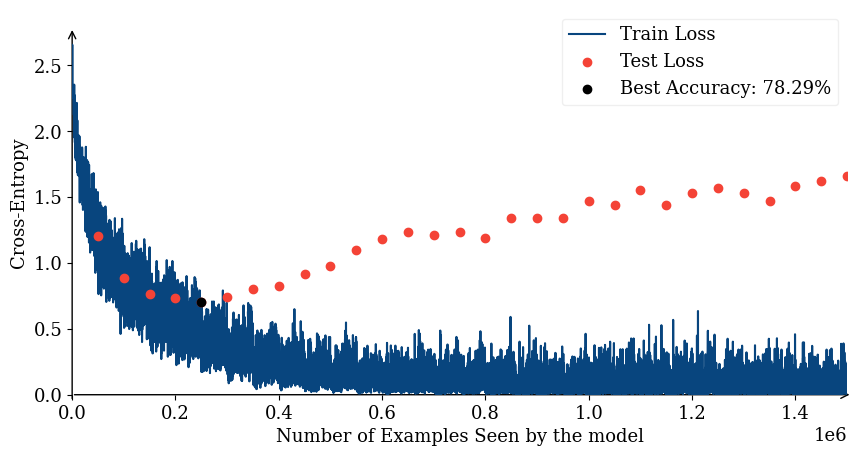

In [70]:
plot("cifar_large_cnn.pt")

If we use batch normalization we can stabilize the training:

In [42]:
model = LargeCNN(batch_norm=True, dropout=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_n_test(model, optimizer, 30, criterion, "cifar_large_cnn_bn.pt")

Epoch: 1 	Training Loss: 1.377527 	Validation Loss: 1.151627
Validation loss decreased (inf --> 1.151627).  Saving model ...
Epoch: 2 	Training Loss: 0.894417 	Validation Loss: 0.934475
Validation loss decreased (1.151627 --> 0.934475).  Saving model ...
Epoch: 3 	Training Loss: 0.721287 	Validation Loss: 0.741299
Validation loss decreased (0.934475 --> 0.741299).  Saving model ...
Epoch: 4 	Training Loss: 0.601858 	Validation Loss: 0.736946
Validation loss decreased (0.741299 --> 0.736946).  Saving model ...
Epoch: 5 	Training Loss: 0.519130 	Validation Loss: 0.658583
Validation loss decreased (0.736946 --> 0.658583).  Saving model ...
Epoch: 6 	Training Loss: 0.438963 	Validation Loss: 0.646755
Validation loss decreased (0.658583 --> 0.646755).  Saving model ...
Epoch: 7 	Training Loss: 0.375962 	Validation Loss: 0.639045
Validation loss decreased (0.646755 --> 0.639045).  Saving model ...
Epoch: 8 	Training Loss: 0.320418 	Validation Loss: 0.737986
Epoch: 9 	Training Loss: 0.276126 

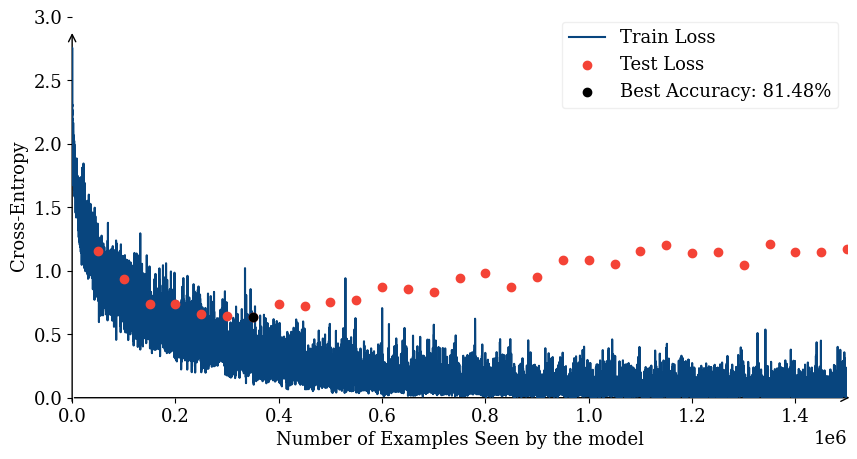

In [72]:
plot("cifar_large_cnn_bn.pt")

Dropout can also help to avoid overfitting:

In [55]:
model = LargeCNN(batch_norm=True, dropout=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_n_test(model, optimizer, 30, criterion, "cifar_large_cnn_bn_dropout.pt")

Epoch: 1 	Training Loss: 1.434861 	Validation Loss: 1.226824
Validation loss decreased (inf --> 1.226824).  Saving model ...
Epoch: 2 	Training Loss: 1.004135 	Validation Loss: 0.917697
Validation loss decreased (1.226824 --> 0.917697).  Saving model ...
Epoch: 3 	Training Loss: 0.816937 	Validation Loss: 0.844841
Validation loss decreased (0.917697 --> 0.844841).  Saving model ...
Epoch: 4 	Training Loss: 0.708206 	Validation Loss: 0.739159
Validation loss decreased (0.844841 --> 0.739159).  Saving model ...
Epoch: 5 	Training Loss: 0.627765 	Validation Loss: 0.668541
Validation loss decreased (0.739159 --> 0.668541).  Saving model ...
Epoch: 6 	Training Loss: 0.567008 	Validation Loss: 0.608081
Validation loss decreased (0.668541 --> 0.608081).  Saving model ...
Epoch: 7 	Training Loss: 0.509372 	Validation Loss: 0.669559
Epoch: 8 	Training Loss: 0.468125 	Validation Loss: 0.591877
Validation loss decreased (0.608081 --> 0.591877).  Saving model ...
Epoch: 9 	Training Loss: 0.419433 

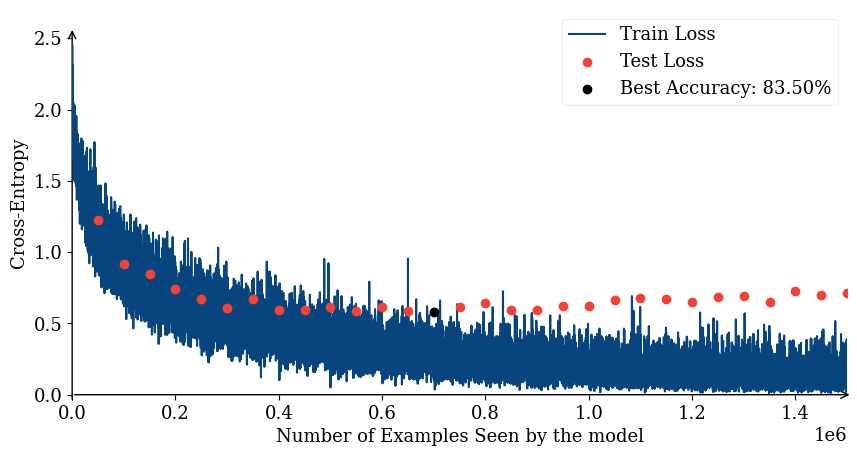

In [74]:
plot("cifar_large_cnn_bn_dropout.pt")

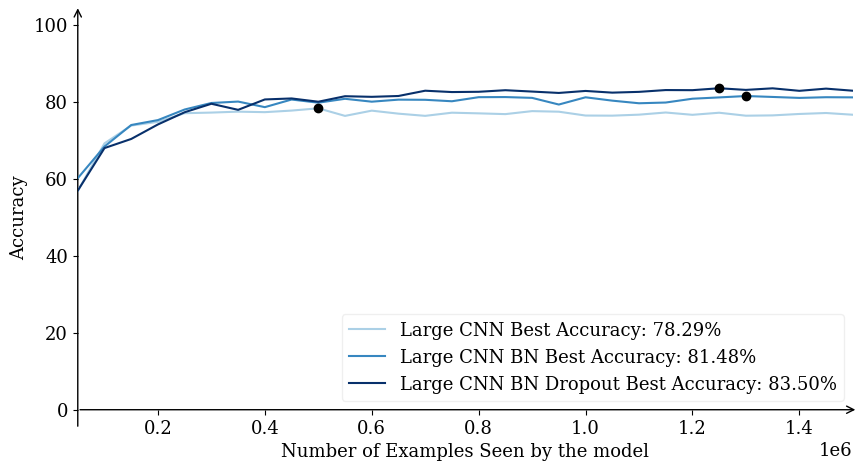

In [88]:
plot_accuracies(
    [
        "cifar_large_cnn.pt",
        "cifar_large_cnn_bn.pt",
        "cifar_large_cnn_bn_dropout.pt",
    ],
    ["Large CNN", "Large CNN BN", "Large CNN BN Dropout"],
)

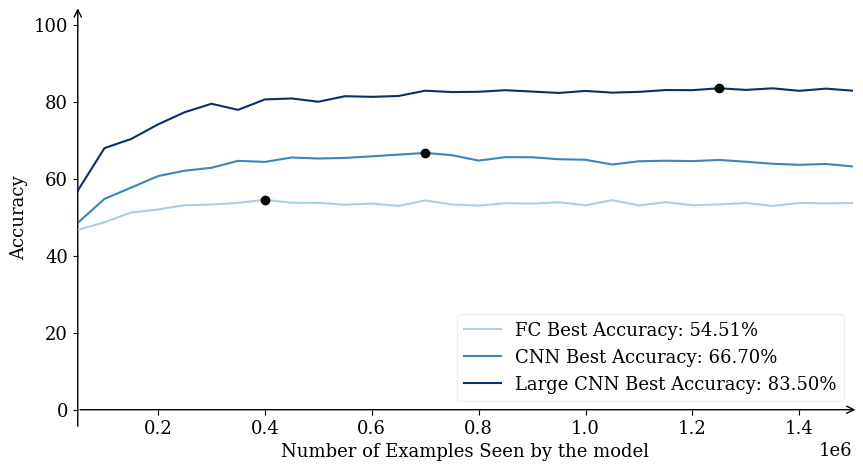

In [90]:
plot_accuracies(
    ["adam_cifar_fc.pt", "cifar_cnn.pt", "cifar_large_cnn_bn_dropout.pt"],
    ["FC", "CNN", "Large CNN"],
)